In [376]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler


import mlrose_hiive
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator, FlipFlopGenerator, ContinuousPeaksGenerator
from mlrose_hiive import SARunner, GARunner, NNGSRunner, RHCRunner, MIMICRunner
from mlrose_hiive import GeomDecay, ArithDecay, ExpDecay

## Preparing Data

In [377]:
# df = pd.read_csv("data/pd_speech_features.csv")


# X = df.drop(['class','id'], axis=1)
# X = StandardScaler().fit_transform(X)
# y = df["class"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1101)

In [378]:
df = pd.read_csv("data/Postures.csv")
df["Class"] = np.where(df["Class"]!=1, 0, 1)
df[:] = np.where(df=="?", 0, df)
X = df.drop(['Class','User'], axis=1)
X = StandardScaler().fit_transform(X)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1101)

## Defining Models

In [380]:
def custom_model(algorithm):
     return mlrose_hiive.NeuralNetwork(hidden_nodes = [10,3], activation = 'relu', \
                                 algorithm = algorithm, max_iters = 100, \
                                 bias = True, is_classifier = True, learning_rate = 0.1, \
                                 early_stopping = True, clip_max = 5, max_attempts = 100, \
                                 random_state = 3, curve=True, pop_size=5, mutation_prob=0.3)

In [381]:
# nn_model = MLPClassifier(hidden_layer_sizes=(5,2), random_state=1101)
nn_model = custom_model('gradient_descent')
rhc_model = custom_model('random_hill_climb')
sa_model = custom_model('simulated_annealing')
ga_model = custom_model('genetic_alg')
mimic_model = custom_model('MIMIC')

In [382]:
def get_learning_curve(estimator, X, y):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1101)
    scorer = make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'))
    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator, 
                                                                      X, y, 
                                                                      cv=cv, #stratified k-fold
                                                                      n_jobs=4,
                                                                      shuffle=True,
                                                                      return_times=True,
                                                                      scoring=scorer)
    return train_sizes, train_scores, test_scores, fit_times, score_times

# train_sizes, train_scores, test_scores, fit_times, score_times = get_learning_curve(nn_model1, X_train, y_train)

In [383]:

class ExperimentModel():
    def __init__(self, name, estimator):
        self.name = name
        self.estimator = estimator
        self.train_sizes = None
        self.train_scores = None
        self.test_scores  = None
        self.fit_times = None
        self.score_times = None
        
estimators = [
    ("Neural Network", nn_model),
    ("RHC", rhc_model),
    ("SA", sa_model),
    ("GA", ga_model),
#     ("MIMIC", mimic_model)

]

models = []

In [384]:
for estimator in tqdm(estimators):
    model = ExperimentModel(estimator[0], estimator[1])
    model.train_sizes, model.train_scores, model.test_scores, model.fit_times, model.score_times = get_learning_curve(estimator[1], X, y)
    models.append(model)
    print("Done with {}".format(estimator[0]))

 25%|██████████████████                                                      | 1/4 [00:46<02:19, 46.38s/it]

Done with Neural Network


 50%|████████████████████████████████████                                    | 2/4 [01:15<01:12, 36.24s/it]

Done with RHC


 75%|██████████████████████████████████████████████████████                  | 3/4 [01:54<00:37, 37.43s/it]

Done with SA


100%|████████████████████████████████████████████████████████████████████████| 4/4 [03:51<00:00, 57.90s/it]

Done with GA


## Plotting Curves

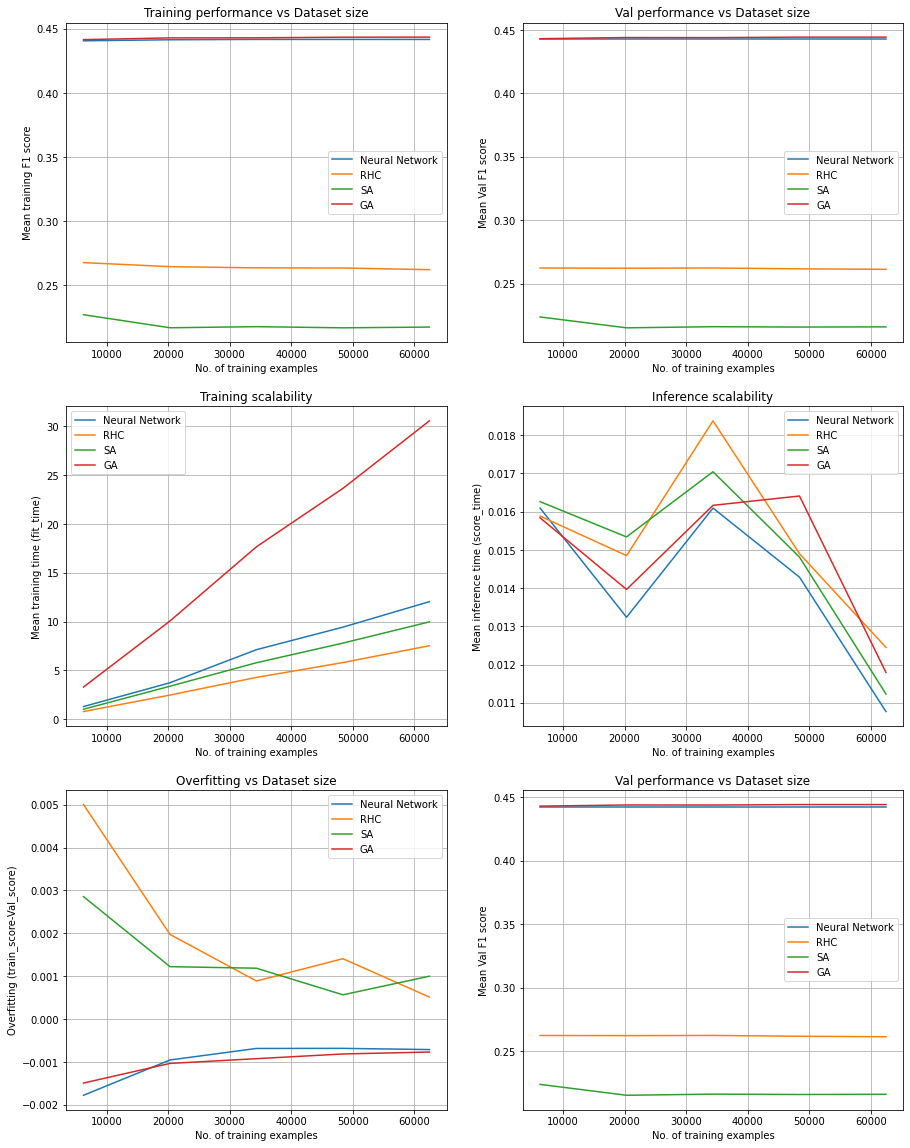

In [399]:
import numpy as np
from matplotlib import pyplot as plt

def generate_plots(models):
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))

#     plt.rcParams.update({'font.size': 10})
    for model in models:
        axes[0, 0].plot(model.train_sizes, np.mean(model.train_scores, axis=1), label=model.name)
        axes[0, 1].plot(model.train_sizes, np.mean(model.test_scores, axis=1), label=model.name)
        axes[1, 0].plot(model.train_sizes, np.mean(model.fit_times, axis=1), label=model.name)
        axes[1, 1].plot(model.train_sizes, np.mean(model.score_times, axis=1), label=model.name)
        axes[2, 0].plot(model.train_sizes, np.mean(model.train_scores, axis=1)-np.mean(model.test_scores, axis=1), label=model.name)
        axes[2, 1].plot(model.train_sizes, np.mean(model.test_scores, axis=1), label=model.name)
        
    #training performance vs no. samVal
    axes[0, 0].grid()
    axes[0, 0].legend(loc="best")
    axes[0, 0].set_xlabel("No. of training examples")
    axes[0, 0].set_ylabel("Mean training F1 score")
    axes[0, 0].set_title("Training performance vs Dataset size")

#     test performance vs no. samples
    axes[0, 1].grid()
    axes[0, 1].legend(loc="best")
    axes[0, 1].set_xlabel("No. of training examples")
    axes[0, 1].set_ylabel("Mean Val F1 score")
    axes[0, 1].set_title("Val performance vs Dataset size")

    #training time vs no. samples
    axes[1, 0].grid()
    axes[1, 0].legend(loc="best")
    axes[1, 0].set_xlabel("No. of training examples")
    axes[1, 0].set_ylabel("Mean training time (fit_time)")
    axes[1, 0].set_title("Training scalability")
    
    #inference time vs no. samples
    axes[1, 1].grid()
    axes[1, 1].legend(loc="best")
    axes[1, 1].set_xlabel("No. of training examples")
    axes[1, 1].set_ylabel("Mean inference time (score_time)")
    axes[1, 1].set_title("Inference scalability")
    
    #overfitting vs no. samples
    axes[2, 0].grid()
    axes[2, 0].legend(loc="best")
    axes[2, 0].set_xlabel("No. of training examples")
    axes[2, 0].set_ylabel("Overfitting (train_score-Val_score)")
    axes[2, 0].set_title("Overfitting vs Dataset size")

    axes[2, 1].grid()
    axes[2, 1].legend(loc="best")
    axes[2, 1].set_xlabel("No. of training examples")
    axes[2, 1].set_ylabel("Mean Val F1 score")
    axes[2, 1].set_title("Val performance vs Dataset size")

generate_plots(models)

In [386]:
models_ind = []

for estimator in tqdm(estimators):
#     model = ExperimentModel(estimator[0], estimator[1])
    start = time.time()
    model = estimator[1].fit(X_train, y_train)
    end = time.time()
    models_ind.append(model)
    print("Done with {}".format(estimator[0]), end-start)

 25%|██████████████████                                                      | 1/4 [00:09<00:27,  9.31s/it]

Done with Neural Network 9.309421062469482


 50%|████████████████████████████████████                                    | 2/4 [00:15<00:14,  7.27s/it]

Done with RHC 5.8379738330841064


 75%|██████████████████████████████████████████████████████                  | 3/4 [00:23<00:07,  7.63s/it]

Done with SA 8.061035871505737


100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.30s/it]

Done with GA 25.981893062591553


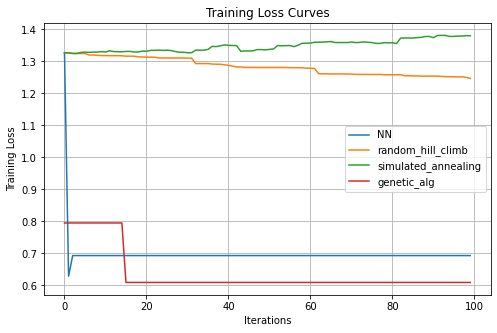

In [401]:
fig, ax = plt.subplots(figsize=(8,5))

plt.plot(-1*models_ind[0].fitness_curve, label="NN")
plt.plot(models_ind[1].fitness_curve[:, 0], label=models_ind[1].algorithm)
plt.plot(models_ind[2].fitness_curve[:,0], label=models_ind[2].algorithm)
plt.plot(models_ind[3].fitness_curve[:,0], label=models_ind[3].algorithm)

ax.set_title('Training Loss Curves')
ax.set_ylabel('Training Loss')
ax.set_xlabel('Iterations')
ax.grid()

ax.legend()